<a href="https://colab.research.google.com/github/shelke16/DL/blob/main/Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [24]:
from google.colab import files
uploaded = files.upload()

Saving imdb_top_1000.csv to imdb_top_1000 (1).csv


In [3]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8KVQGE_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8KVQGE_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8KVQGE_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [25]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)


In [26]:
import tensorflow as tf
import tensorflow_hub as hub

# ... (your other imports)

embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

# Wrap the hub_layer within a Lambda layer
hub_layer_wrapped = tf.keras.layers.Lambda(lambda x: hub_layer(x))


model = tf.keras.Sequential([
    hub_layer_wrapped,  # Using the wrapped layer.
    tf.keras.layers.Dense(32, activation='relu', name='hidden-layer-2'),
    tf.keras.layers.Dense(16, activation='relu', name='hidden-layer-3'),
    tf.keras.layers.Dense(1, name='output-layer')
])

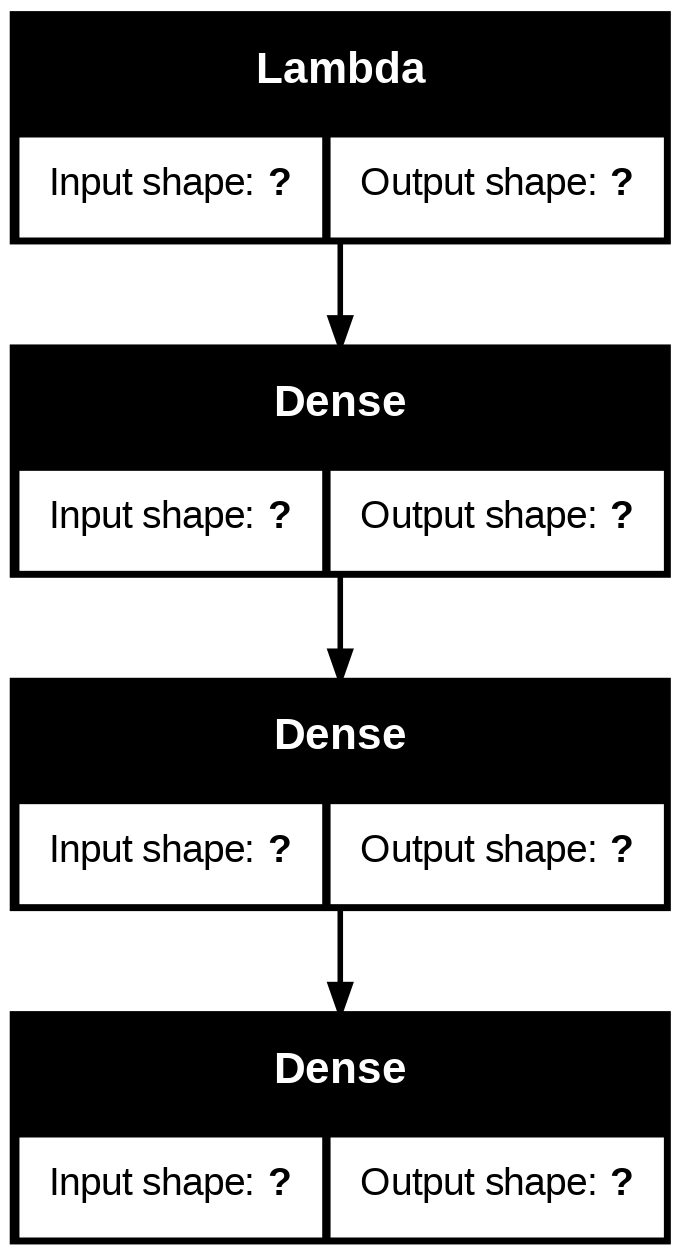

In [28]:

# Build the model by specifying the input shape
# Assuming your input data is a batch of strings
model.build(input_shape=(None,)) #  None represents the batch size.

tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-2 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-3 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output-layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4878 - loss: 0.8401 - val_accuracy: 0.5888 - val_loss: 0.6966
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6316 - loss: 0.6538 - val_accuracy: 0.6872 - val_loss: 0.5975
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7231 - loss: 0.5577 - val_accuracy: 0.5843 - val_loss: 1.3298
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5945 - loss: 1.2964 - val_accuracy: 0.6962 - val_loss: 0.6352
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6893 - loss: 0.5888 - val_accuracy: 0.7292 - val_loss: 0.5641


In [31]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - 48ms/step - accuracy: 0.7370 - loss: 0.5566
loss: 0.557
compile_metrics: 0.737


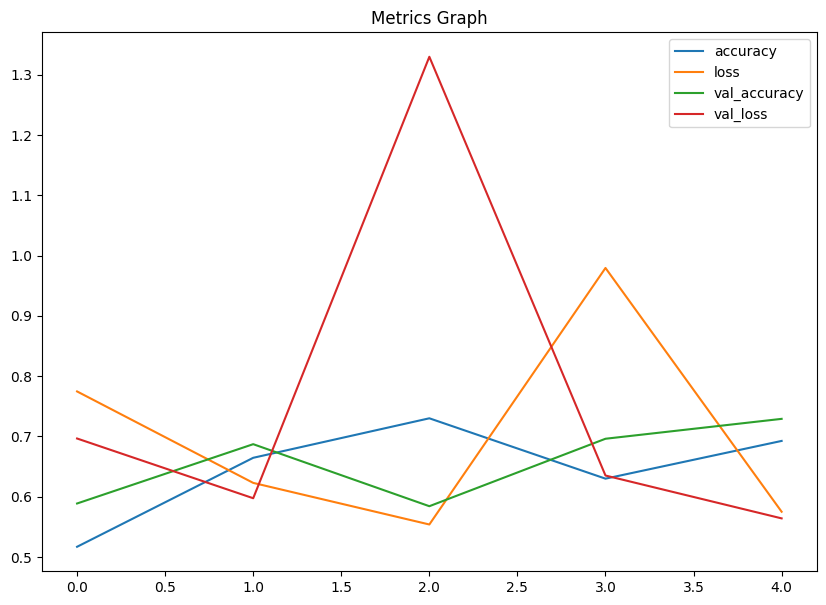

In [32]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.title("Metrics Graph")
plt.show()

In [33]:
texts = []
true_labels = []
for text, label in test_data:
    texts.append(text.numpy())
    true_labels.append(label.numpy())
texts = np.array(texts)
true_labels = np.array(true_labels)

In [34]:
predicted_probs = model.predict(tf.convert_to_tensor(texts, dtype=tf.string))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [35]:
predicted_labels = (predicted_probs > 0.5).astype(int)


report = metrics.classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.71      0.81      0.75     12500
    Positive       0.78      0.67      0.72     12500

    accuracy                           0.74     25000
   macro avg       0.74      0.74      0.74     25000
weighted avg       0.74      0.74      0.74     25000



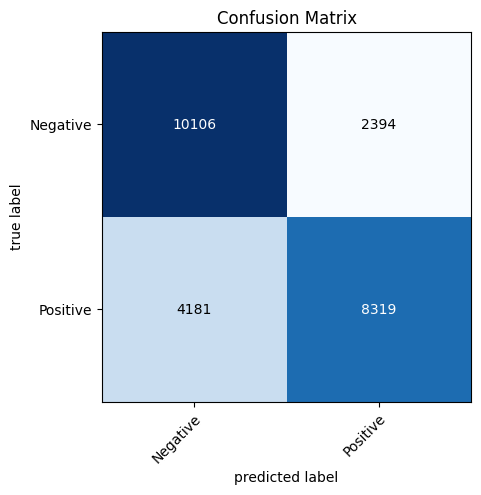

In [36]:
cm = metrics.confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()